In [14]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

In [3]:
ames = pd.read_csv("AmesHousing.csv")

# cleaning the data
clean_cols = ames.isna().sum() < 100
ames = ames.loc[:,clean_cols]

ames = ames.dropna()
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,3,2010,WD,Normal,189900


14.2 Practice Activity - Ridge Regression

In [4]:
X = ames.drop(["SalePrice"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'),
    make_column_selector(dtype_include = object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include = np.number))
  ],
  remainder = "passthrough"
)

ridge_pipeline_1 = Pipeline([
  ("preprocessing", ct),
  ("ridge", Ridge(alpha = 1))
])

ols_pipeline_1 = Pipeline([
    ("preprocessing", ct),
    ("model", LinearRegression())
])

In [5]:
# cross validate
ols_cv = cross_val_score(ols_pipeline_1, X, y, cv = 5, scoring = "r2").mean()
ridge_cv = cross_val_score(ridge_pipeline_1, X, y, cv = 5, scoring = "r2").mean()

In [6]:
# fit & coefficients
ridge_pipeline_1.fit(X, y)
ols_pipeline_1.fit(X, y)
ridge_coefs = ridge_pipeline_1["ridge"].coef_
ols_coefs = ols_pipeline_1["model"].coef_
coefs = pd.DataFrame({
    "ols_coefs": ols_coefs,
    "ridge_coefs": ridge_coefs})
coefs

,ols_coefs,ridge_coefs
0,-4867.807365,-5685.128185
1,2417.076748,1810.210480
2,-8615.350275,-5766.816674
3,8376.916348,7990.272440
4,4455.979775,3379.902569
...,...,...
251,2676.009161,2919.767196
252,2774.632363,1412.333375
253,-5128.736234,-4399.537112
254,-841.282767,-785.511877


/usr/local/lib/python3.12/dist-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


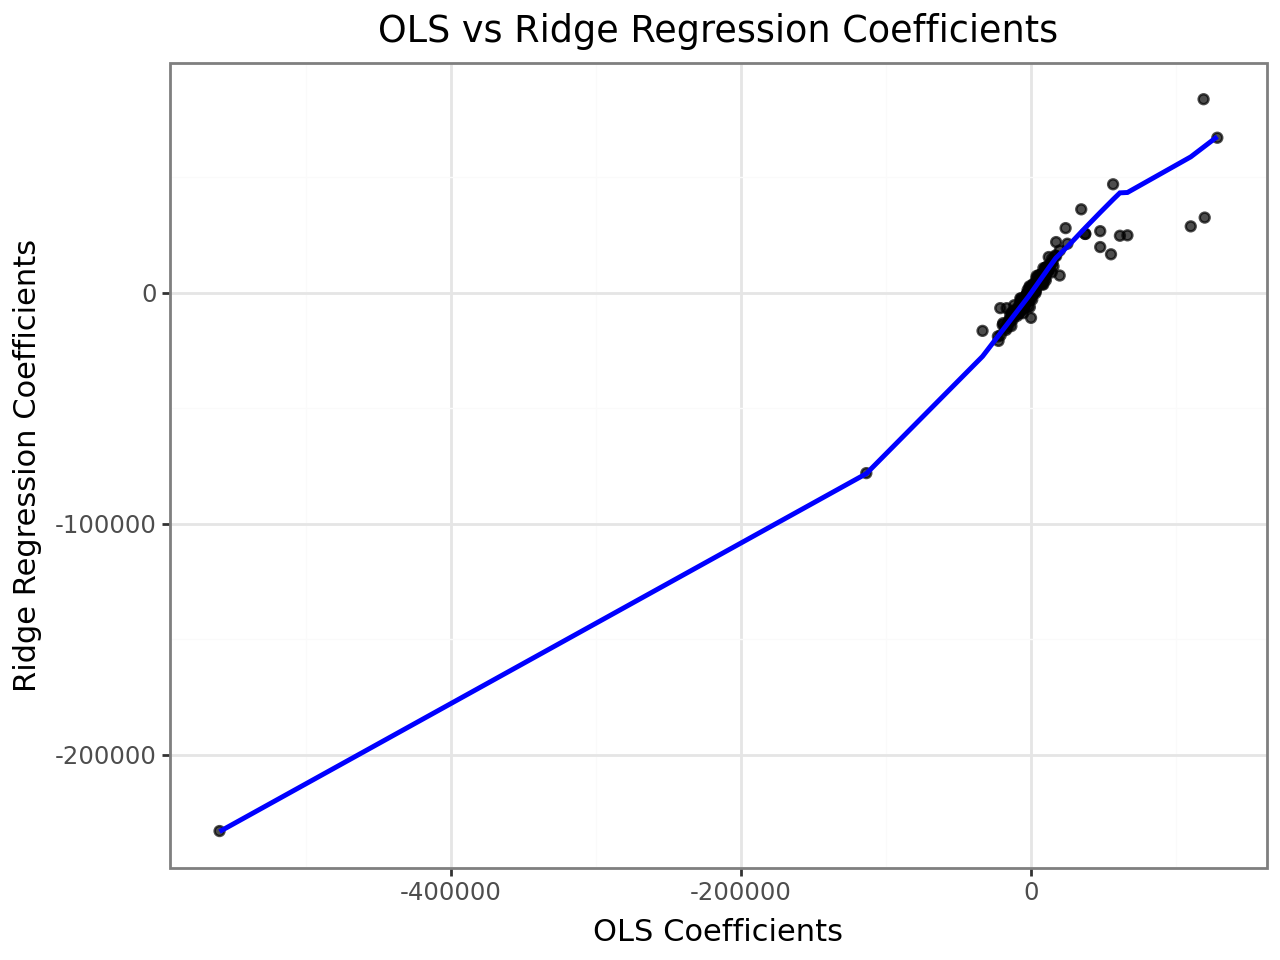

In [7]:
from plotnine import ggplot, aes, labs, theme_bw, geom_point, geom_smooth
(
    ggplot(coefs, aes(
        x = "ols_coefs",
        y = "ridge_coefs"))
    + geom_point(alpha = 0.7)
    + geom_smooth(color = "blue")
    + labs(
          x = "OLS Coefficients",
          y = "Ridge Regression Coefficients",
          title = "OLS vs Ridge Regression Coefficients")
    + theme_bw()
)

14.2.1 Practice Activity - Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

tune_ridge = Pipeline([("preprocessing", ct),
                       ("model", Ridge())])

param_grid = {"model__alpha": np.logspace(1, 3, 5, 10)}

ridge_cv = GridSearchCV(tune_ridge, param_grid, cv = 5, scoring = "r2", refit = True)
ridge_cv.fit(X, y)

print("Best Ridge lambda:", ridge_cv.best_params_["model__alpha"])
print("Best Ridge CV R Sq:", ridge_cv.best_score_)

Best Ridge lambda: 10.0
Best Ridge CV R Sq: 0.864134504659351


14.3.1 Practice Activity - LASSO

In [19]:
lasso_pipeline_1 = Pipeline([
  ("preprocessing", ct),
  ("lasso", Lasso())
])

ridge_pipeline_1 = Pipeline([
  ("preprocessing", ct),
  ("ridge", Ridge(alpha = 1))
])

ols_pipeline_1 = Pipeline([
    ("preprocessing", ct),
    ("model", LinearRegression())
])

In [20]:
lasso_pipeline_1.fit(X, y)
ridge_pipeline_1.fit(X, y)
ols_pipeline_1.fit(X, y)
lasso_coefs = lasso_pipeline_1["lasso"].coef_
ridge_coefs = ridge_pipeline_1["ridge"].coef_
ols_coefs = ols_pipeline_1["model"].coef_
coefs = pd.DataFrame({
    "lasso_coefs" : lasso_coefs,
    "ols_coefs": ols_coefs,
    "ridge_coefs": ridge_coefs})
coefs

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.220e+09, tolerance: 1.793e+09


,lasso_coefs,ols_coefs,ridge_coefs
0,-4613.086547,-4867.807365,-5685.128185
1,2401.755908,2417.076748,1810.210480
2,-4998.337527,-8615.350275,-5766.816674
3,8335.466646,8376.916348,7990.272440
4,4521.706347,4455.979775,3379.902569
...,...,...,...
251,2667.079995,2676.009161,2919.767196
252,2752.849466,2774.632363,1412.333375
253,-5098.902677,-5128.736234,-4399.537112
254,-837.948056,-841.282767,-785.511877


In [36]:
tune_lasso = Pipeline([("preprocessing", ct),
                       ("model", Lasso())])

param_grid = {"model__alpha": np.logspace(1, 3, 5, 10)}

lasso_cv = GridSearchCV(tune_lasso, param_grid, cv = 5, scoring = "r2", refit = True)
lasso_cv.fit(X, y)

print("Best LASSO lambda:", lasso_cv.best_params_["model__alpha"])
print("Best LASSO CV R Sq:", lasso_cv.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.029e+09, tolerance: 1.348e+09
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.317e+09, tolerance: 1.348e+09
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.185e+09, tolerance: 1.463e+09


Best LASSO lambda: 100.0
Best LASSO CV R Sq: 0.8669227516032727


/usr/local/lib/python3.12/dist-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


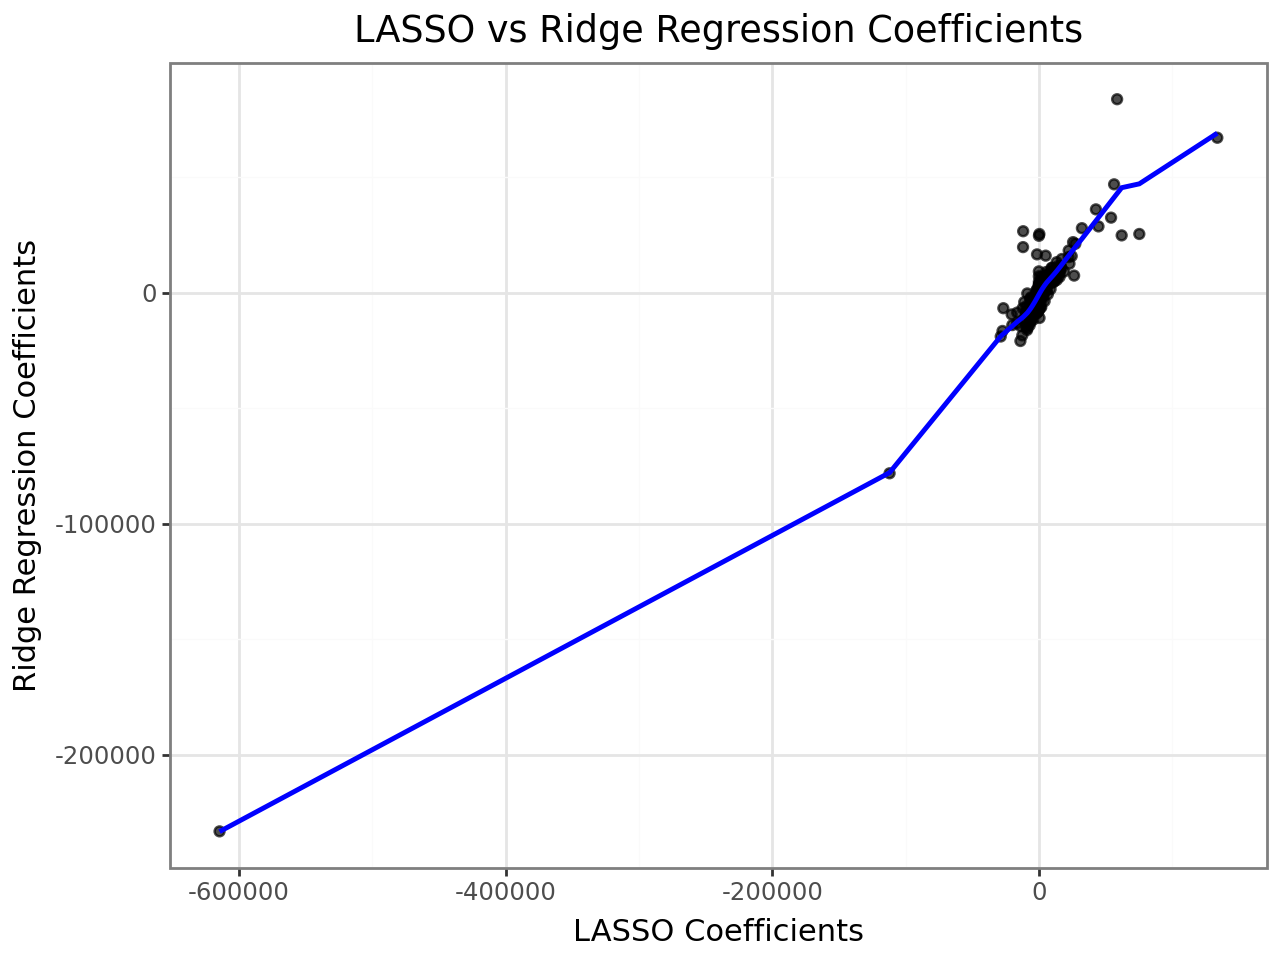

In [23]:
# compared to ridge regression
(
    ggplot(coefs, aes(
        x = "lasso_coefs",
        y = "ridge_coefs"))
    + geom_point(alpha = 0.7)
    + geom_smooth(color = "blue")
    + labs(
          x = "LASSO Coefficients",
          y = "Ridge Regression Coefficients",
          title = "LASSO vs Ridge Regression Coefficients")
    + theme_bw()
)

/usr/local/lib/python3.12/dist-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


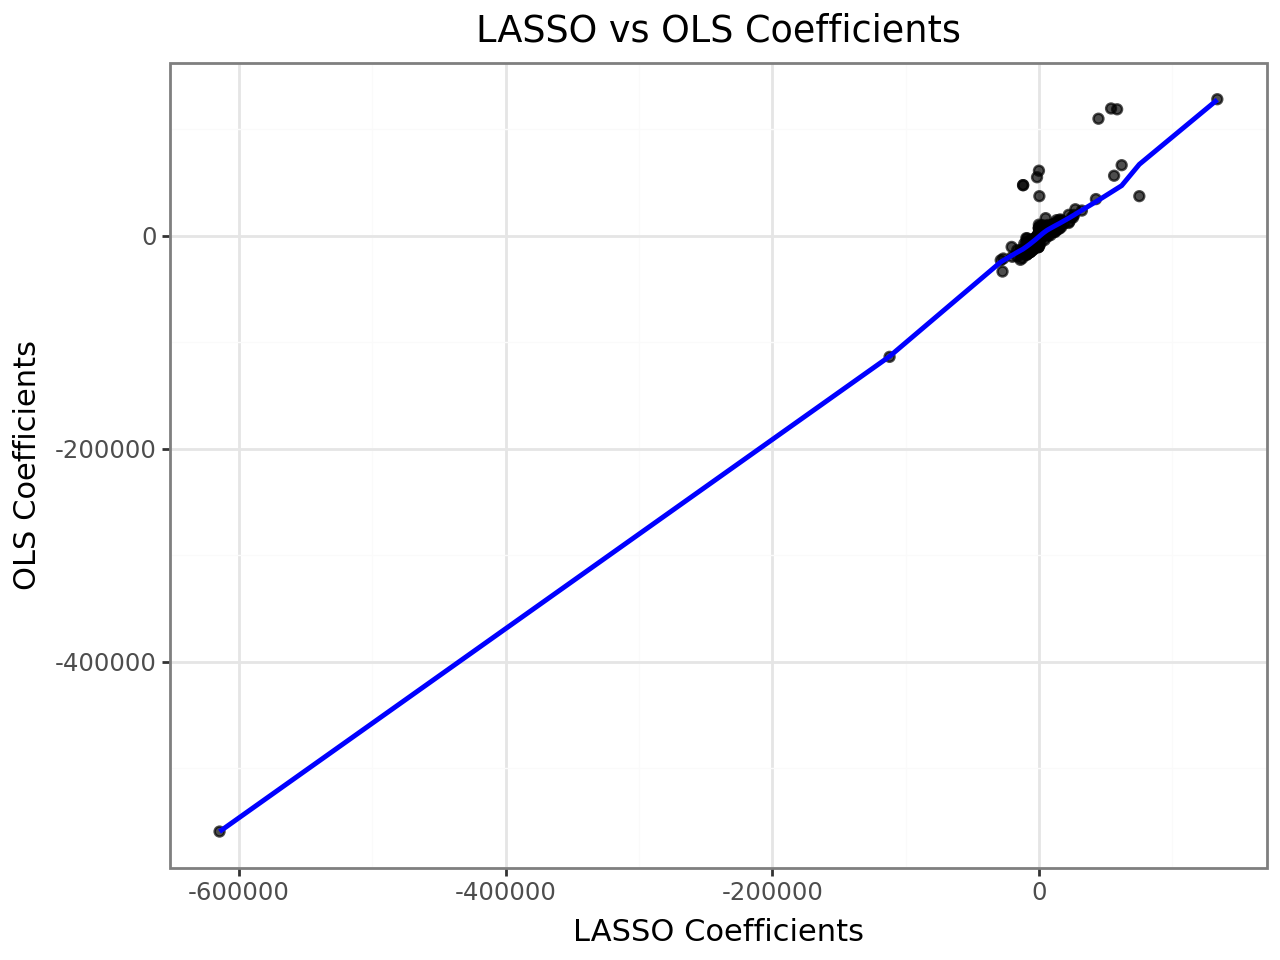

In [24]:
# compared to ols coefficients
(
    ggplot(coefs, aes(
        x = "lasso_coefs",
        y = "ols_coefs"))
    + geom_point(alpha = 0.7)
    + geom_smooth(color = "blue")
    + labs(
          x = "LASSO Coefficients",
          y = "OLS Coefficients",
          title = "LASSO vs OLS Coefficients")
    + theme_bw()
)

14.3.3 Practice Activity - Elastic Net

In [25]:
elastic_pipeline_1 = Pipeline([
  ("preprocessing", ct),
  ("elastic_net", ElasticNet())
])

ridge_pipeline_1 = Pipeline([
  ("preprocessing", ct),
  ("ridge", Ridge(alpha = 1))
])

ols_pipeline_1 = Pipeline([
    ("preprocessing", ct),
    ("model", LinearRegression())
])

In [28]:
elastic_pipeline_1.fit(X, y)
ridge_pipeline_1.fit(X, y)
ols_pipeline_1.fit(X, y)
elastic_coefs = elastic_pipeline_1["elastic_net"].coef_
ridge_coefs = ridge_pipeline_1["ridge"].coef_
ols_coefs = ols_pipeline_1["model"].coef_
coefs = pd.DataFrame({
    "elastic_net_coefs" : elastic_coefs,
    "ols_coefs": ols_coefs,
    "ridge_coefs": ridge_coefs})
coefs

,elastic_net_coefs,ols_coefs,ridge_coefs
0,-127.631125,-4867.807365,-5685.128185
1,236.617646,2417.076748,1810.210480
2,-19.460154,-8615.350275,-5766.816674
3,-62.070090,8376.916348,7990.272440
4,1031.954331,4455.979775,3379.902569
...,...,...,...
251,2588.817413,2676.009161,2919.767196
252,86.653346,2774.632363,1412.333375
253,-3162.714777,-5128.736234,-4399.537112
254,-124.757967,-841.282767,-785.511877


In [35]:
tune_elastic = Pipeline([("preprocessing", ct),
                       ("model", ElasticNet())])

param_grid = {"model__alpha": np.logspace(1, 3, 5, 10)}

elastic_cv = GridSearchCV(tune_elastic, param_grid, cv = 5, scoring = "r2", refit = True)
elastic_cv.fit(X, y)

print("Best Elastic Net lambda:", elastic_cv.best_params_["model__alpha"])
print("Best Elastic Net CV R Sq:", elastic_cv.best_score_)

Best Elastic Net lambda: 10.0
Best Elastic Net CV R Sq: 0.6745997375777475


In [42]:
tune_elastic = Pipeline([
    ("preprocessing", ct),
    ("model", ElasticNet(max_iter=1000))
])

param_grid = {
    "model__alpha": np.logspace(1, 3, 5, 10),
    "model__l1_ratio": np.linspace(0.0, 1.0, 5)
}

elastic_cv = GridSearchCV(tune_elastic, param_grid, cv = 5, scoring = "r2", refit = True)
elastic_cv.fit(X, y)

print("Best Elastic Net lambda:", elastic_cv.best_params_["model__alpha"])
print("Best Elastic Net alpha:", elastic_cv.best_params_["model__l1_ratio"])
print("Best Elastic Net CV R Sq:", elastic_cv.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.457e+12, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.845e+12, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/usr/local/lib/pyt

Best Elastic Net lambda: 100.0
Best Elastic Net alpha: 1.0
Best Elastic Net CV R Sq: 0.8669227516032727


/usr/local/lib/python3.12/dist-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


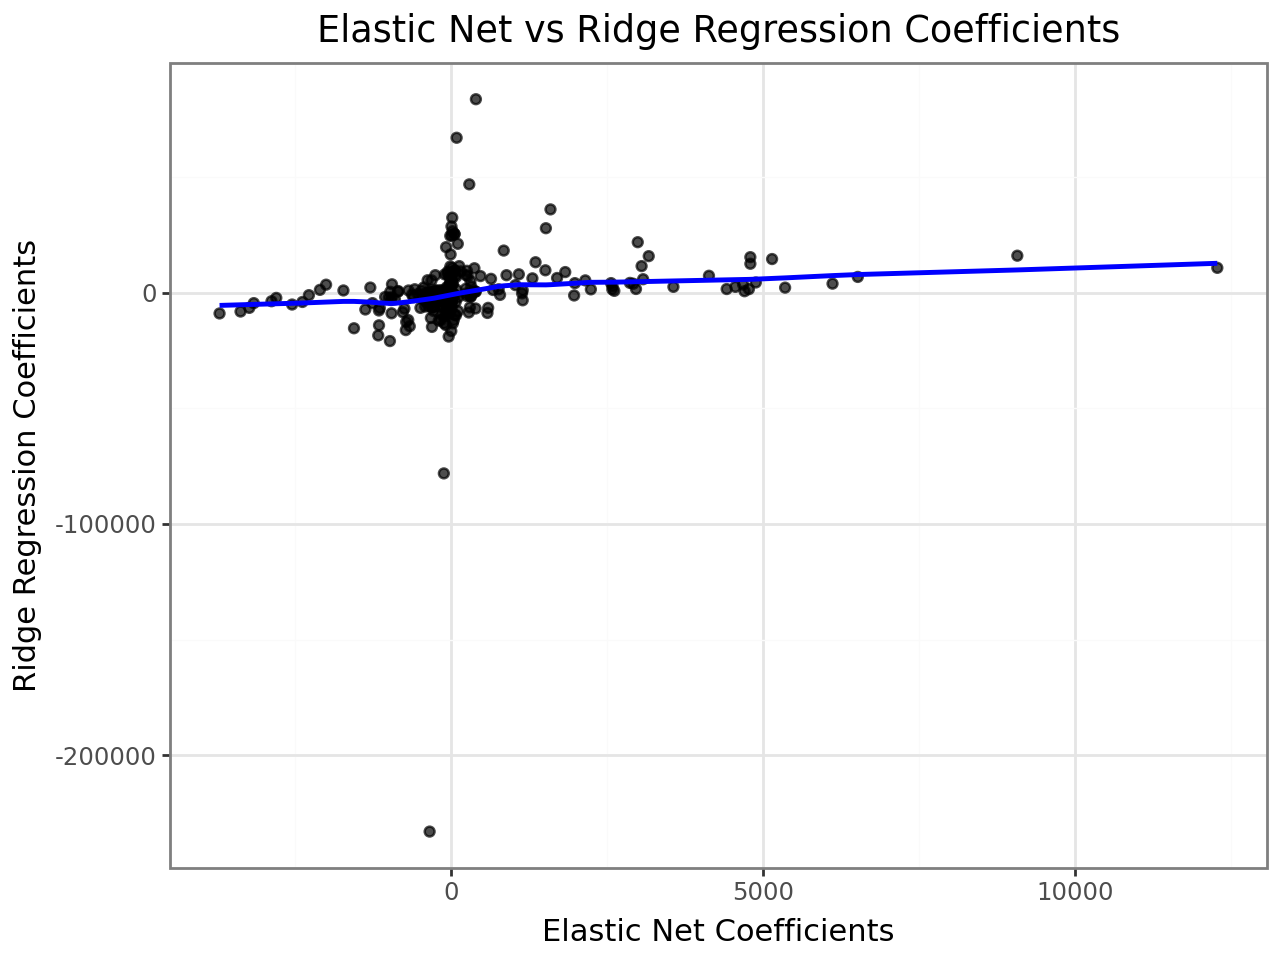

In [33]:
# compared to ridge regression
(
    ggplot(coefs, aes(
        x = "elastic_net_coefs",
        y = "ridge_coefs"))
    + geom_point(alpha = 0.7)
    + geom_smooth(color = "blue")
    + labs(
          x = "Elastic Net Coefficients",
          y = "Ridge Regression Coefficients",
          title = "Elastic Net vs Ridge Regression Coefficients")
    + theme_bw()
)

/usr/local/lib/python3.12/dist-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


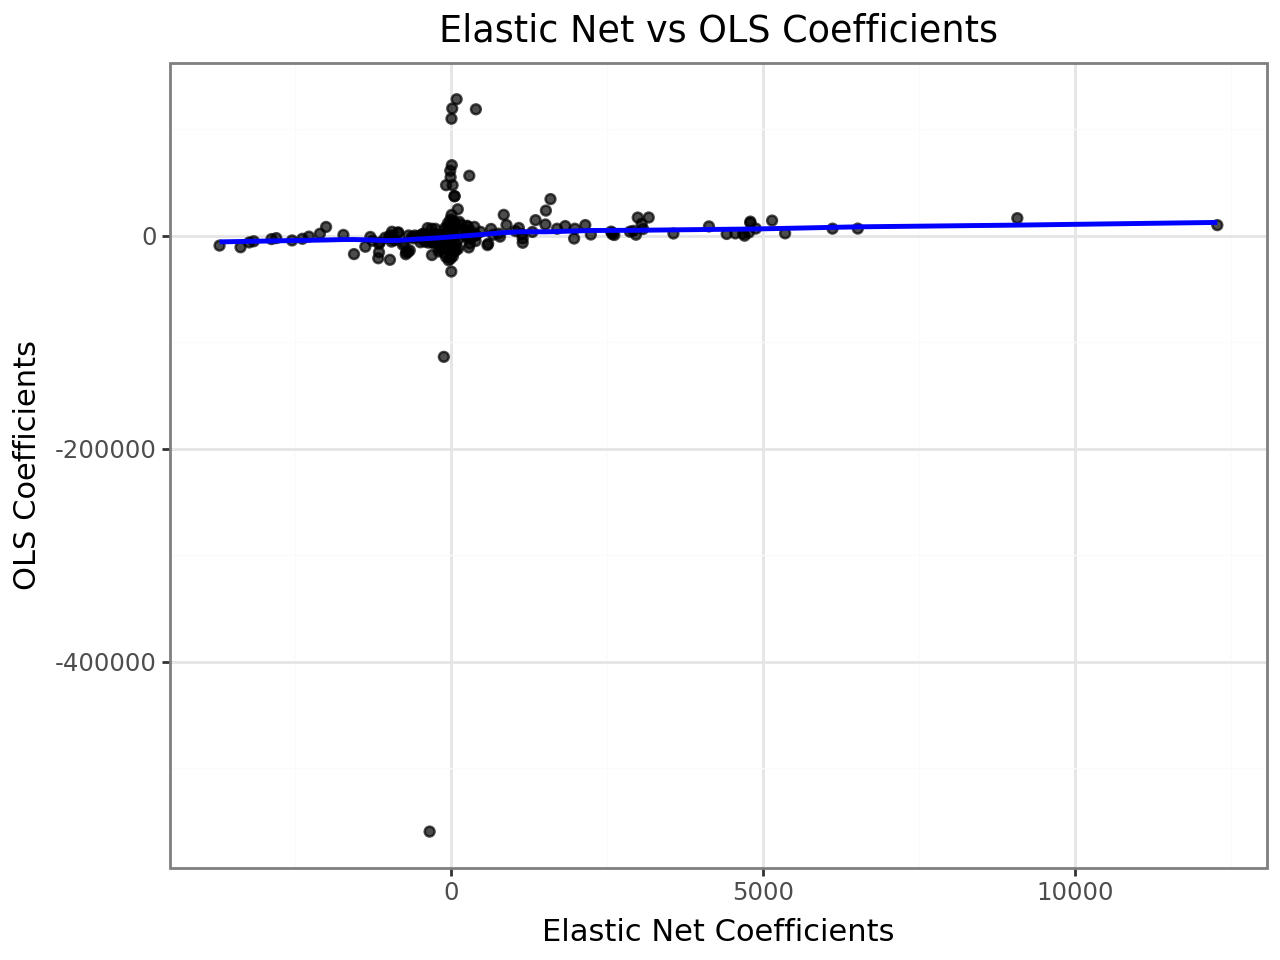

In [34]:
# compared to ols coefficients
(
    ggplot(coefs, aes(
        x = "elastic_net_coefs",
        y = "ols_coefs"))
    + geom_point(alpha = 0.7)
    + geom_smooth(color = "blue")
    + labs(
          x = "Elastic Net Coefficients",
          y = "OLS Coefficients",
          title = "Elastic Net vs OLS Coefficients")
    + theme_bw()
)